### calculate_thai_income_tax

In [8]:
def calculate_thai_income_tax(net_assessable_income):
    tax = 0
    income = net_assessable_income

    # ตารางอัตราภาษี (ขั้นเงินได้สุทธิ, อัตราภาษี)
    brackets = [
        (150000, 0.00),  # 0 - 150,000 ยกเว้น
        (300000, 0.05),  # 150,001 - 300,000 ร้อยละ 5
        (500000, 0.10),  # 300,001 - 500,000 ร้อยละ 10
        (750000, 0.15),  # 500,001 - 750,000 ร้อยละ 15
        (1000000, 0.20), # 750,001 - 1,000,000 ร้อยละ 20
        (2000000, 0.25), # 1,000,001 - 2,000,000 ร้อยละ 25
        (5000000, 0.30), # 2,000,001 - 5,000,000 ร้อยละ 30
        (float('inf'), 0.35) # 5,000,001 ขึ้นไป ร้อยละ 35
    ]

    prev_limit = 0

    for limit, rate in brackets:
        if income <= prev_limit:
            break

        # ส่วนเงินได้ที่ตกอยู่ในขั้นนี้
        taxable_amount = min(income, limit) - prev_limit
        tax += taxable_amount * rate

        prev_limit = limit

    return tax

### optimize_dividend_tax    
    """
    ฟังก์ชันเปรียบเทียบ Final Tax vs ยื่นเครดิตภาษี
    
    base_net_income: เงินได้สุทธิจากงานประจำ/ธุรกิจ (หลังหักลดหย่อน) *ก่อน* รวมปันผล
    dividend_amount: เงินปันผลที่ได้รับ (ก่อนหัก ณ ที่จ่าย)
    corporate_tax_rate: อัตราภาษีของบริษัทหุ้นที่จ่ายปันผล (เช่น 20, 30)
    """

In [9]:
def optimize_dividend_tax(base_net_income, dividend_amount, corporate_tax_rate):
    """
    ฟังก์ชันเปรียบเทียบ Final Tax vs ยื่นเครดิตภาษี

    base_net_income: เงินได้สุทธิจากงานประจำ/ธุรกิจ (หลังหักลดหย่อน) *ก่อน* รวมปันผล
    dividend_amount: เงินปันผลที่ได้รับ (ก่อนหัก ณ ที่จ่าย)
    corporate_tax_rate: อัตราภาษีของบริษัทหุ้นที่จ่ายปันผล (เช่น 20, 30)
    """

    # ทางเลือกที่ 1 : Final Tax (หัก ณ ที่จ่าย 10% แล้วจบ)
    withholding_tax = dividend_amount * 0.10
    net_received_final_tax = dividend_amount - withholding_tax

    # ภาษีจากรายได้อื่น (ไม่เอาปันผลมารวม)
    tax_base_case = calculate_thai_income_tax(base_net_income)

    # เงินเหลือสุทธิ (รายได้อื่นหลังภาษี + ปันผลหลังหัก 10%)
    total_net_wealth_option1 = (base_net_income - tax_base_case) + net_received_final_tax

    # ทางเลือกที่ 2 : Tax Credit (ยื่นรวมคำนวณ)
    # สูตรเครดิตภาษี = ปันผล x (ภาษีบริษัท / (100 - ภาษีบริษัท))
    if corporate_tax_rate > 0:
        tax_credit_ratio = corporate_tax_rate / (100 - corporate_tax_rate)
        tax_credit_value = dividend_amount * tax_credit_ratio
    else:
        tax_credit_value = 0 # กรณีบริษัทได้รับการยกเว้นภาษี (BOI) จะไม่มีเครดิต

    # รายได้ปันผลที่จะนำไปคิดภาษี = ปันผลรับจริง + เครดิตภาษี (Grossed-up)
    gross_dividend_income = dividend_amount + tax_credit_value

    # เงินได้สุทธิรวมใหม่ (งานประจำ + ปันผล Grossed-up)
    total_net_income_option2 = base_net_income + gross_dividend_income

    # คำนวณภาษีใหม่
    total_tax_liability = calculate_thai_income_tax(total_net_income_option2)

    # ภาษีที่ต้องจ่ายจริง = ภาษีคำนวณใหม่ - เครดิตภาษีปันผล - ภาษีหัก ณ ที่จ่าย 10% (ที่โดนหักไปแล้ว)
    # แต่ในที่นี้เราดูแค่ Wealth สุทธิ จึงเอา (รายได้รวม - ภาษีคำนวณใหม่)
    # *Note: เครดิตภาษีถือเป็นเงินที่เรา "จ่ายไปแล้ว" ทางอ้อม จึงเอามาหักออกจากภาระภาษีได้

    total_net_wealth_option2 = (base_net_income + gross_dividend_income) - total_tax_liability

    # --- เปรียบเทียบผลลัพธ์ ---
    diff = total_net_wealth_option2 - total_net_wealth_option1

    result = {
        "dividend_received": dividend_amount,
        "cit_rate": corporate_tax_rate,
        "option1_final_tax_wealth": round(total_net_wealth_option1, 2),
        "option2_credit_tax_wealth": round(total_net_wealth_option2, 2),
        "difference": round(diff, 2),
        "recommendation": "",
        "reason": ""
    }

    if diff > 0:
        result["recommendation"] = "✅ ควรยื่นภาษี (ขอเครดิต)"
        result["reason"] = f"คุณจะได้เงินเพิ่มขึ้น {diff:,.2f} บาท (เพราะฐานภาษีคุณต่ำกว่าภาษีบริษัท)"
    else:
        result["recommendation"] = "🛑 เลือก Final Tax (หัก 10% จบ)"
        result["reason"] = f"ถ้าขอยื่นคุณจะเสียเงินเพิ่ม {-diff:,.2f} บาท (เพราะฐานภาษีคุณสูงแล้ว)"

    return result

# ==========================================
#  ส่วนทดสอบระบบ (User Test)
# ==========================================

# 1. ข้อมูลผู้ใช้ (สมมติ)
user_net_income = 240000

# 2. ข้อมูลหุ้น (สมมติหุ้น PTT)
dividend_amount = 10000  # ได้ปันผลมา 10,000 บาท
company_cit = 20         # บริษัทเสียภาษี 20%

# 3. คำนวณ
analysis = optimize_dividend_tax(user_net_income, dividend_amount, company_cit)

# 4. แสดงผล
print(f"--- ผลการวิเคราะห์การยื่นภาษี ---")
print(f"เงินได้สุทธิเดิมของคุณ: {user_net_income:,} บาท")
print(f"ได้รับปันผล: {dividend_amount:,} บาท (จากบริษัทที่เสียภาษี {company_cit}%)")
print("-" * 30)
print(f"ทางเลือก 1 (Final Tax): เงินเหลือเข้ากระเป๋าจริง = {analysis['option1_final_tax_wealth']:,} บาท")
print(f"ทางเลือก 2 (ยื่นเครดิต): เงินเหลือเข้ากระเป๋าจริง = {analysis['option2_credit_tax_wealth']:,} บาท")
print("-" * 30)
print(f"สรุป: {analysis['recommendation']}")
print(f"เหตุผล: {analysis['reason']}")

--- ผลการวิเคราะห์การยื่นภาษี ---
เงินได้สุทธิเดิมของคุณ: 240,000 บาท
ได้รับปันผล: 10,000 บาท (จากบริษัทที่เสียภาษี 20%)
------------------------------
ทางเลือก 1 (Final Tax): เงินเหลือเข้ากระเป๋าจริง = 244,500.0 บาท
ทางเลือก 2 (ยื่นเครดิต): เงินเหลือเข้ากระเป๋าจริง = 247,375.0 บาท
------------------------------
สรุป: ✅ ควรยื่นภาษี (ขอเครดิต)
เหตุผล: คุณจะได้เงินเพิ่มขึ้น 2,875.00 บาท (เพราะฐานภาษีคุณต่ำกว่าภาษีบริษัท)


# Scoring

## Factor1_T-DTS

In [12]:
! pip install yfinance

In [13]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import pytz

# 1. รายชื่อหุ้น SET50 
set50_tickers = [
    "ADVANC.BK","AOT.BK","AWC.BK","BANPU.BK","BBL.BK","BDMS.BK","BEM.BK","BGRIM.BK","BH.BK","BJC.BK",
    "BPP.BK","CPALL.BK","CPF.BK","CPN.BK","CRC.BK","DELTA.BK","EGCO.BK","ESSO.BK","GULF.BK","HMPRO.BK",
    "IRPC.BK","KBANK.BK","KTB.BK","KTC.BK","LH.BK","MINT.BK","MTC.BK","OR.BK","OSP.BK",
    "PTT.BK","PTTEP.BK","PTTGC.BK","RATCH.BK","SAWAD.BK","SCB.BK","SCC.BK","SCGP.BK","TISCO.BK","TLI.BK",
    "TOP.BK","TTB.BK","TU.BK","VGI.BK","WHA.BK","GLOBAL.BK","BAM.BK","CPAXT.BK","GPSC.BK","BLA.BK"
]

def analyze_tdts_history(tickers, start_year=2022, end_year=2024):
    all_data = []
    print(f"กำลังดึงข้อมูลย้อนหลังปี {start_year}-{end_year} ...")

    for symbol in tickers:
        try:
            # ดึงข้อมูลหุ้น
            stock = yf.Ticker(symbol)

            # 1. ดึงประวัติราคา (ย้อนหลังเผื่อไว้หน่อย)
            # ดึงตั้งแต่ต้นปี start_year ถึงปัจจุบัน
            history = stock.history(start=f"{start_year}-01-01", end=f"{end_year+1}-12-31")

            # 2. ดึงประวัติปันผล
            dividends = stock.dividends

            # แปลง timezone ให้ตรงกัน (เพื่อเทียบวันที่)
            if not history.empty:
                history.index = history.index.normalize() # ตัดเวลาออกเหลือแค่วันที่

            if not dividends.empty:
                 dividends.index = dividends.index.normalize()

            # กรองเอาเฉพาะปันผลในช่วงปีที่ต้องการ
            mask = (dividends.index.year >= start_year) & (dividends.index.year <= end_year)
            target_dividends = dividends.loc[mask]

            if target_dividends.empty:
                continue

            # 3. วนลูปคำนวณ T-DTS สำหรับการจ่ายปันผล "แต่ละครั้ง"
            for date, amount in target_dividends.items():
                # วันที่จ่ายปันผลใน yfinance คือ Ex-Date
                ex_date = date

                # ตรวจสอบว่ามีข้อมูลราคาในวัน Ex-Date หรือไม่
                if ex_date not in history.index:
                    continue

                # หา Index ของวัน Ex-Date
                loc_ex = history.index.get_loc(ex_date)

                # ถ้าเป็นวันแรกของข้อมูล จะไม่มี Cum Date (วันก่อนหน้า)
                if loc_ex == 0:
                    continue

                # วัน Cum Date คือวันทำการก่อนหน้า Ex-Date 1 วัน
                loc_cum = loc_ex - 1

                # ดึงข้อมูลราคาปิด (Close Price)
                p_ex = history.iloc[loc_ex]['Close']
                p_cum = history.iloc[loc_cum]['Close']
                date_cum = history.index[loc_cum]

                # --- คำนวณสูตร T-DTS ---
                # Dividend Yield (DY)
                dy = (amount / p_cum) * 100

                # Price Drop (PD)
                pd_pct = ((p_cum - p_ex) / p_cum) * 100

                # T-DTS
                if dy != 0:
                    t_dts = pd_pct / dy
                else:
                    t_dts = 0

                # เก็บข้อมูลลง List
                all_data.append({
                    'Stock': symbol.replace('', ''),
                    'Year': ex_date.year,
                    'Ex-Date': ex_date.strftime('%Y-%m-%d'),
                    'DPS (Baht)': amount,
                    'P_cum': p_cum,
                    'P_ex': p_ex,
                    'DY (%)': dy,
                    'PD (%)': pd_pct,
                    'T-DTS': t_dts
                })

        except Exception as e:
            print(f"Error checking {symbol}: {e}")

    # สร้าง DataFrame
    df = pd.DataFrame(all_data)

    # เรียงลำดับตาม ชื่อหุ้น -> ปี -> วันที่
    if not df.empty:
        df = df.sort_values(by=['Stock', 'Ex-Date'], ascending=[True, False])

    return df

# --- รันฟังก์ชัน ---
df_results_T_DTS = analyze_tdts_history(set50_tickers)
df_results_T_DTS

กำลังดึงข้อมูลย้อนหลังปี 2022-2024 ...


$ESSO.BK: possibly delisted; no timezone found
$ESSO.BK: possibly delisted; no timezone found


Error checking ESSO.BK: 'RangeIndex' object has no attribute 'year'


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
5,ADVANC.BK,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563
4,ADVANC.BK,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146
3,ADVANC.BK,2023,2023-08-18,4.0000,201.021667,203.775375,1.989835,-1.369856,-0.688427
2,ADVANC.BK,2023,2023-02-22,4.2400,185.480804,187.500015,2.285951,-1.088636,-0.476229
1,ADVANC.BK,2022,2022-08-19,3.4500,173.601181,173.115402,1.987314,0.279825,0.140805
...,...,...,...,...,...,...,...,...,...
202,WHA.BK,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358194,-0.531779
201,WHA.BK,2023,2023-11-22,0.0669,4.474906,4.481165,1.495003,-0.139868,-0.093557
200,WHA.BK,2023,2023-05-11,0.1003,3.973449,3.973717,2.524256,-0.006750,-0.002674
199,WHA.BK,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186834,-0.090268


In [14]:
df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]

C:\Users\natta\AppData\Local\Temp\ipykernel_2828\3432150815.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
153,SCB.BK,2023,2023-09-13,2.50,95.108742,95.527725,2.628570,-0.440531,-0.167593
152,SCB.BK,2023,2023-04-17,5.19,82.244469,83.220161,6.310455,-1.186332,-0.187995


<Axes: >

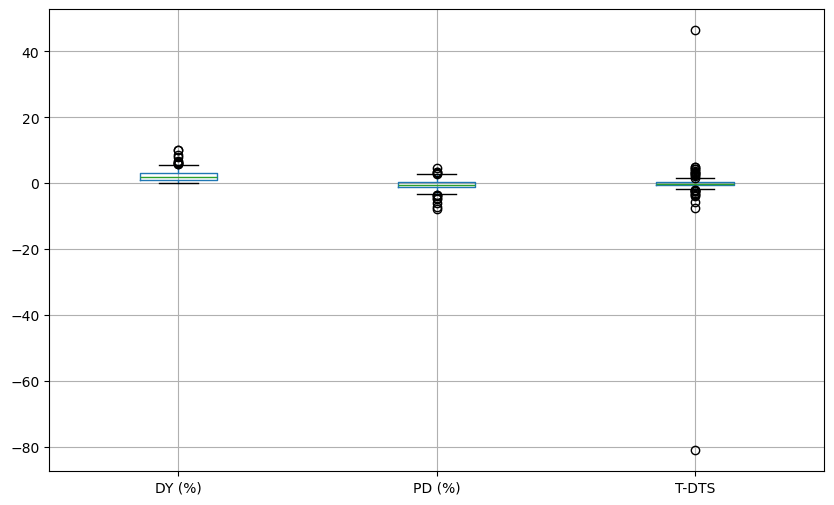

In [15]:
df_results_T_DTS[['DY (%)', 'PD (%)', 'T-DTS']].boxplot(figsize=(10, 6))

In [19]:
# หาตัวการที่ทำให้กราฟเบี้ยว
outlier = df_results_T_DTS[(df_results_T_DTS['T-DTS'] < -10) | (df_results_T_DTS['T-DTS'] > 10)]
outlier

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
34,BGRIM.BK,2023,2023-03-14,0.035000,36.166214,34.543156,0.096775,4.487775,46.373095
150,SAWAD.BK,2024,2024-05-08,0.010455,33.019634,33.865894,0.031663,-2.562900,-80.943096
